In [20]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import TensorDataset

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(device)

cpu


In [22]:
#Loading the data set
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston_raw = pd.read_csv('../data/housing.csv', header=None, delimiter=r"\s+", names=column_names)

data = boston_raw.copy()

In [23]:
#let us try to visualize our data 
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [24]:
#Splitting the dataset into  training and testing dataset
train, test = train_test_split(data,  test_size = 0.1)
train_targets = train.pop("MEDV")
test_targets = test.pop("MEDV")

train_stats = train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
CRIM,455.0,3.611968,8.832250,0.00632,0.078805,0.24522,3.504645,88.9762
ZN,455.0,12.104396,24.082379,0.00000,0.000000,0.00000,20.000000,100.0000
INDUS,455.0,10.923934,6.901645,0.46000,4.950000,8.56000,18.100000,27.7400
CHAS,455.0,0.063736,0.244551,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,455.0,0.554118,0.118120,0.38500,0.448000,0.53800,0.631000,0.8710
RM,455.0,6.301349,0.705094,3.56100,5.897000,6.22300,6.638500,8.7800
AGE,455.0,68.280220,28.001842,2.90000,45.050000,76.50000,93.700000,100.0000
DIS,455.0,3.839504,2.133602,1.13700,2.068550,3.27970,5.266000,12.1265
RAD,455.0,9.382418,8.628589,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,455.0,405.002198,167.868780,187.00000,278.000000,330.00000,666.000000,711.0000


In [25]:
train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
289,0.04297,52.5,5.32,0,0.405,6.565,22.9,7.3172,6,293.0,16.6,371.72,9.51
251,0.21409,22.0,5.86,0,0.431,6.438,8.9,7.3967,7,330.0,19.1,377.07,3.59
314,0.36920,0.0,9.90,0,0.544,6.567,87.3,3.6023,4,304.0,18.4,395.69,9.28
363,4.22239,0.0,18.10,1,0.770,5.803,89.0,1.9047,24,666.0,20.2,353.04,14.64
184,0.08308,0.0,2.46,0,0.488,5.604,89.8,2.9879,3,193.0,17.8,391.00,13.98


In [26]:
test.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
326,0.30347,0.0,7.38,0,0.493,6.312,28.9,5.4159,5,287.0,19.6,396.90,6.15
214,0.28955,0.0,10.59,0,0.489,5.412,9.8,3.5875,4,277.0,18.6,348.93,29.55
67,0.05789,12.5,6.07,0,0.409,5.878,21.4,6.4980,4,345.0,18.9,396.21,8.10
483,2.81838,0.0,18.10,0,0.532,5.762,40.3,4.0983,24,666.0,20.2,392.92,10.42
478,10.23300,0.0,18.10,0,0.614,6.185,96.7,2.1705,24,666.0,20.2,379.70,18.03


In [27]:
def df_to_tensor(df):
    return torch.from_numpy(df.values).float().to(device)
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

In [28]:
#Converting training data into tensors for Pytorch

train_dataset = TensorDataset(df_to_tensor(norm(train)), torch.Tensor([[x] for x in list(train_targets)]))
x_test, y_test = (df_to_tensor(norm(test)),[x for x in list(test_targets)])

train_dataloader = DataLoader(train_dataset,batch_size=8)
# test_dataloader = DataLoader(test_dataset,batch_size=5)



In [29]:
class NeuralNetwork(nn.Module):
    def __init__(self,in_size, out_size):
        super(NeuralNetwork, self).__init__()
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_size, 13),
            nn.ReLU(),
            nn.Linear(13, 5),
            nn.ReLU(),
            nn.Linear(5, out_size),
            )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [30]:
# Define model
model = NeuralNetwork(13, 1).to(device) # nn.Linear(in_features,out_features)


In [31]:
#Define the loss function
loss_fun = nn.MSELoss()

In [32]:
# Define SGD optimizer with learning rate 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
# Utility function to train the model
def lrmodel(num_epochs, model, loss_fun, optimizer, train_dl):
    # train_dl.to(device)
    # Repeat for given number of epochs
    for epoch in range(num_epochs):
        
        # Train with batches of data
        for xb,yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            # 1. Generate predictions
            pred = model(xb)
            
            # 2. Calculate loss
            loss = loss_fun(pred, yb)
            
            # 3. Compute gradients
            loss.backward()
            
            # 4. Update parameters using gradients
            optimizer.step()
            
            # 5. Reset the gradients to zero
            optimizer.zero_grad()
        
        # Print the progress
        if (epoch+1) % 100 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

In [34]:
#Training for 100 epochs
num_epochs=1000
lrmodel(num_epochs, model, loss_fun, optimizer, train_dataloader)


Epoch [100/1000], Loss: 6.1061
Epoch [200/1000], Loss: 5.9857
Epoch [300/1000], Loss: 5.5923
Epoch [400/1000], Loss: 5.9964
Epoch [500/1000], Loss: 6.2673
Epoch [600/1000], Loss: 6.4401
Epoch [700/1000], Loss: 6.5392
Epoch [800/1000], Loss: 6.1989
Epoch [900/1000], Loss: 5.9463
Epoch [1000/1000], Loss: 5.9602


In [35]:
#Predicting for X_test
y_pred_test = model(x_test)

In [36]:
#Converting predictions from tensor objects into a list
import numpy
y_pred_test = [y_pred_test[x].item() for x in range(len(y_pred_test))]
# Comparing Actual and predicted values
# print(numpy.multiply(y_test,1000))
df = {}
df['Actual Observation'] = numpy.multiply(y_test,1000)
df['Predicted Salary'] = numpy.multiply(y_pred_test,1000) 
df = pd.DataFrame(df)
print(df)

    Actual Observation  Predicted Salary
0              23000.0      21770.620346
1              23700.0      33833.385468
2              22000.0      18286.266327
3              21800.0      25078.426361
4              14600.0      17105.743408
5              32500.0      30719.690323
6              20900.0      18052.331924
7              18800.0      20560.777664
8              16200.0      16082.075119
9              25000.0      28956.501007
10             26700.0      30855.611801
11             50000.0      35589.908600
12             21700.0      20708.763123
13             22400.0      23129.974365
14             20000.0      23330.034256
15             13300.0      15497.776031
16             23800.0      17625.396729
17             20400.0      19760.412216
18             14300.0      14240.573883
19             19300.0      20305.152893
20             11900.0      16371.042252
21             19200.0      19811.580658
22             24400.0      21578.542709
23             1

In [37]:
from sklearn.metrics import mean_absolute_error

# Let's check how much we are off on average
# y_pred = model(df_to_tensor(norm(train)))
mae = mean_absolute_error(df['Actual Observation'], df['Predicted Salary'])

print(f"We are off on average by {round(mae, 2)} US dollars, while the mean price of a house in the dataset is {round(test_targets.mean()*1000, 2)}.")

We are off on average by 2720.88 US dollars, while the mean price of a house in the dataset is 21247.06.


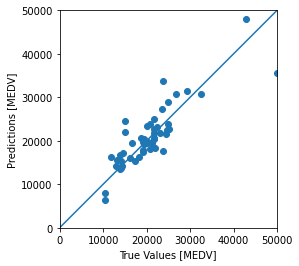

In [38]:
a = plt.axes(aspect='equal')
plt.scatter(df['Actual Observation'],  df['Predicted Salary'])
plt.xlabel('True Values [MEDV]')
plt.ylabel('Predictions [MEDV]')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)